## Working with Inception architecture

In [1]:
from model import create_model
nn4_small2 = create_model()

In [2]:
nn4_small2.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 48, 48, 64)   256         conv1[0][0]                      
_______________________________________________________________________________________

In [3]:
from keras import backend as K
from keras.layers import Input, Layer
from keras.models import Model

# Anchor, +ve, -ve Input
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

#Embedding vectors
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a,p,n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])
# Model to be trained with A, P, N images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

In [4]:
nn4_small2_train.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 128)          3743280     input_2[0][0]                    
                                                                 input_3[0][0]         

In [5]:
from data import triplet_generator

generator = triplet_generator()

nn4_small2_train.compile(loss=None, optimizer='adam')
nn4_small2_train.fit_generator(generator, epochs=10, steps_per_epoch=100)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
100/100 [==============================] - 25s 250ms/step - loss: 0.8083
Epoch 2/10
100/100 [==============================] - 26s 264ms/step - loss: 0.7725
Epoch 3/10
100/100 [==============================] - 27s 269ms/step - loss: 0.8076
Epoch 4/10
100/100 [==============================] - 27s 270ms/step - loss: 0.8002
Epoch 5/10
100/100 [==============================] - 27s 268ms/step - loss: 0.7999
Epoch 6/10
100/100 [==============================] - 27s 270ms/step - loss: 0.8002
Epoch 7/10
100/100 [==============================] - 27s 270ms/step - loss: 0.7999
Epoch 8/10
100/100 [==============================] - 27s 269ms/step - loss: 0.8002
Epoch 9/10
100/100 [==============================] - 27s 271ms/step - loss: 0.7997
Epoch 10/10
100/100 [==============================] - 27s 273ms/step - loss: 0.8005


## Working with OpenFace Model

In [20]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('weights/nn4.small2.v1.h5')

In [21]:
# Preparing the dataset
import os.path
import numpy as np

class Metadata():
    def __init__(self, base, name, file):
        self.base = base
        self.name = name
        self.file = file
        
    def __repr__(self):
        return self.image_path()
    
    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for j in os.listdir(os.path.join(path, i)):
            ext = os.path.splitext(j)[1]
            if ext=='.jpg' or ext == '.jpeg':
                metadata.append(Metadata(path, i, j))
    return np.array(metadata)

In [22]:
metadata = load_metadata('dataset')

In [23]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]

alignment = AlignDlib('models/landmarks.dat')

def show_original_and_aligned(img_index):
    plt.figure(figsize=(10,10))
    original = load_image(metadata[img_index].image_path())
    
    bb = alignment.getLargestFaceBoundingBox(original)
  
    aligned = alignment.align(96, original, bb, landmarkIndices=AlignDlib.INNER_EYES_AND_BOTTOM_LIP)
    
    # Show original image
    plt.subplot(131)
    plt.imshow(original)

    # Show original image with bounding box
    plt.subplot(132)
    plt.imshow(original)
    plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

    # Show aligned image
    plt.subplot(133)
    plt.imshow(aligned)

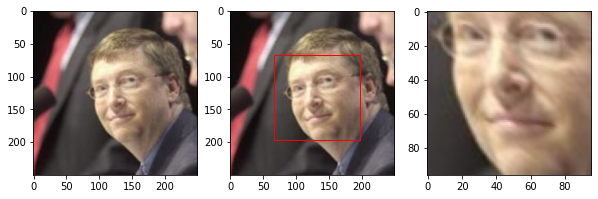

In [24]:
show_original_and_aligned(23)

In [25]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [26]:
from progressbar import ProgressBar

num_images = metadata.shape[0]
progress = ProgressBar(num_images)
progress.start()

embedded = np.zeros((num_images, 128))

for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    img = align_image(img)
    img = (img/255.).astype(np.float32)
    embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
    progress.update(i)

In [27]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1-emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(10,5))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

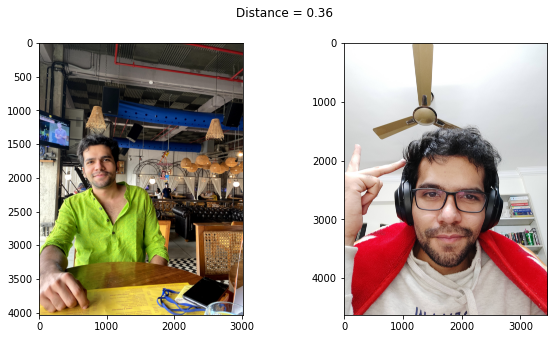

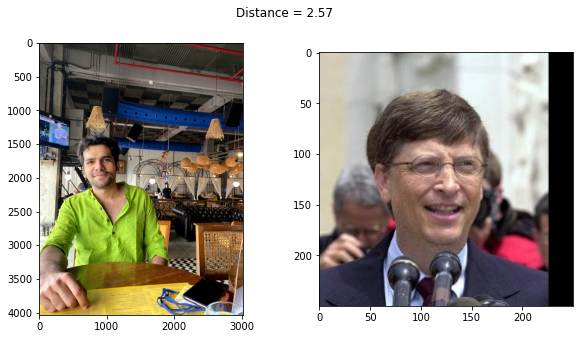

In [34]:
show_pair(69,68)
show_pair(69,25)

## Threshold value for Face Verification

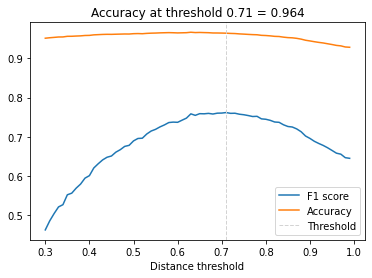

In [35]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

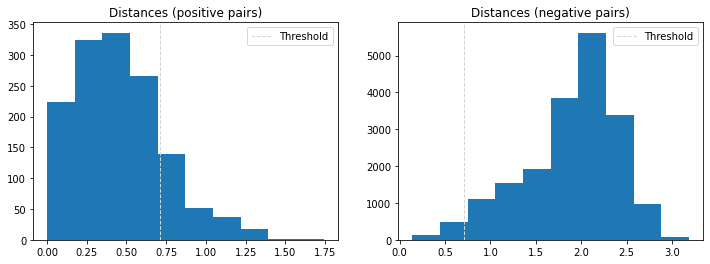

In [36]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (positive pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (negative pairs)')
plt.legend();

## Face Recognition - KNN/SVM

In [37]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

test_idx = np.arange(metadata.shape[0]) % 2 != 0
train_idx = np.arange(metadata.shape[0]) % 2 == 0

# 50 train examples of 10 identities 
X_train = embedded[train_idx]
# 50 test examples of 10 identities
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
y_pred_svc = knn.predict(X_test)
acc_svc = accuracy_score(y_test, y_pred_svc)

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.9305555555555556, SVM accuracy = 0.9305555555555556


In [38]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

def show_prediction(example_idx):
    plt.figure()
    example_image = load_image(metadata[test_idx][example_idx].image_path())
    example_prediction = knn.predict([embedded[test_idx][example_idx]])
    example_identity = encoder.inverse_transform(example_prediction)[0]

    plt.imshow(example_image)
    plt.title(f'Recognized as {example_identity}');
    
def show_predictions(indexes):
    plt.figure(figsize=(16,16))
    
    for i, idx in enumerate(indexes[:16]):
        example_image = load_image(metadata[test_idx][idx].image_path())
        example_prediction = knn.predict([embedded[test_idx][idx]])
        example_identity = encoder.inverse_transform(example_prediction)[0]

        plt.subplot(4,4,i+1)
        plt.imshow(example_image)
        plt.title(f'Recognized as {example_identity}');        

In [ ]:
show_predictions(range(33,38))